![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Dataset: MNIST

In this Notebook we will show you how to load and preprocess the MNIST dataset. 

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/data_and_models/Data-Model-MNIST-CNN.ipynb)



Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [1]:
# %pip install tensorflow

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [2]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [3]:
# %cd drive/MyDrive

In [4]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [5]:
# %cd XAI-Tutorials/data_and_models

### Imports

Let's start with importing all required Python packages.

In [6]:
# Load the required packages
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D

import joblib
import numpy as np
import matplotlib.pyplot as plt

2023-09-06 18:46:37.783995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [7]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

--------

## The MNIST dataset: Data and Model Loading

Let's use the MNIST dataset to see how SHAP can be used to explain image classification models. The MNIST dataset contains images of handwritten digits with numbers from 0 to 9. 

<center><img src="../docs/source/_figures/dataset_digits.png" width="700" /></center>

<font size=1> Source:
[Link](https://towardsdatascience.com/part-5-training-the-network-to-read-handwritten-digits-c2288f1a2de3)

Let's load the MNIST dataset from tensoflow datasets.

In [8]:
# load the MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Before using the images for our model, we need to properly transform and normalize the images.

In [9]:
# normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# transform
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

Let's have a look at some of the images.

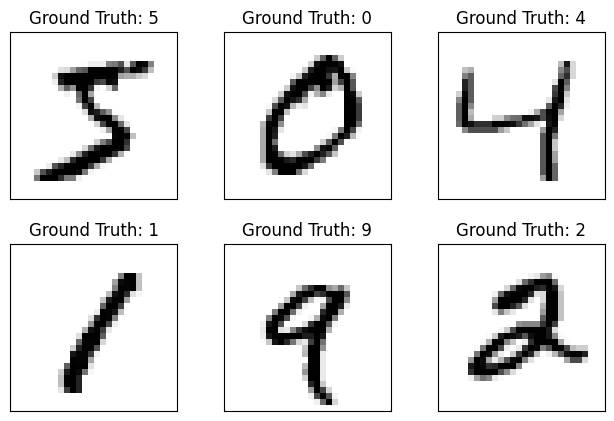

In [10]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray_r')
  plt.title("Ground Truth: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

We define a simple 2D CNN model with kernel size of 3 and the ReLU activation function using tensorflow. Then we train the model for a small number of epochs on our training images.

*Note: this a very basic model to showcase how SHAP works for image classification.*

In [11]:
# define our model
input1 = Input(shape=(28,28,1))
input2 = Input(shape=(28,28,1))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit([X_train, X_train], y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1646 - accuracy: 0.9497
Epoch 2/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0626 - accuracy: 0.9807
Epoch 3/3
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0420 - accuracy: 0.9865


Great, now you trained your CNN model with a high accuracy of 98%!  

Let's now save the model in a ``joblib`` file, such that we can load the trained model into other notebooks later on.

In [12]:
# Save the model with joblib
data_and_model = [X_train, X_test, y_train, y_test, model]
joblib.dump(data_and_model, open('./model_cnn_mnist.joblib', 'wb'))